Machine learning partie 1 <b>Supervisé</b>:
    
   - I - <b>Splitting data</b>
    
   - II - <b>training models</b>
    
   - III - <b>Learning curves & validation</b>
    
   - IV - <b>Fine tuning</b>
    
   - V - <b>Classification metrics</b>
   
   - VI - <b>final test</b>


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")

In [2]:
data = pd.read_csv('/Users/lucas/Desktop/Polytech/IG4/S7/projet_DS/mail_pre_process.csv')
df = data[['DayWeek','Cat_1_level_1',
       'Cat_1_level_2', 'Cat_1_weight','Years', 'Month', 'Day', 'Hours',
       'content_char_len', 'content_char_length_category',  'To_count']]

class_mapping = {1999: 0, 2000: 1, 2001: 2, 2002: 3}

df = df.replace({'Years':class_mapping})

In [3]:
print(df.shape)
df.head()

(99913, 11)


,DayWeek,Cat_1_level_1,Cat_1_level_2,Cat_1_weight,Years,Month,Day,Hours,content_char_len,content_char_length_category,To_count
0,0,-1,-1,-1,2,5,14,23,20,1,1
1,4,-1,-1,-1,2,5,4,20,773,2,1
2,2,-1,-1,-1,1,10,18,10,29,1,1
3,0,-1,-1,-1,1,10,23,13,180,1,1
4,3,-1,-1,-1,1,8,31,12,33,1,1


In [4]:
data.columns

Index(['Unnamed: 0', 'DayWeek', 'Cat_1_level_1', 'Cat_1_level_2',
       'Cat_1_weight', 'Cat_2_level_1', 'Cat_2_level_2', 'Cat_2_weight',
       'Cat_3_level_1', 'Cat_3_level_2',
       ...
       'thanks', 'thursday', 'today', 'toute', 'trading', 'tuesday', 'via',
       'ward', 'web', 'would'],
      dtype='object', length=110)

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

<center><h3>Partie 1 - supervisée.</h3></center>

Après avoir préparé et exploré nos données, nous devons choisir un algorithme performant pour pouvoir effectuer une classification efficace. Cependant, une classification efficace, n'est pas la seule caractéristiques à prendre en compte.

Il existe des compromis entre plusieurs caractéristiques des algorithmes:

- Vitesse d'entraînement.
- Utilisation de la mémoire.
- Précision prédictive sur les nouvelles données.
- Transparence ou inteprétabilité.

Il n'existe pas de meilleur modèle, certains seront très performant dans un cas d'utilisation mais parfois peu performant dans d'autre cas d'utilisation. Nous allons utiliser plusieurs modèles, les comparer puis en sélectionner un nombre restreint puis les comparer à nouveau, et ce jusqu'à avoir un (ou plusieurs) modèle convenable.

<center><h3>0 - Rappel sur la variable de classification</h3></center>

2    53758
1    40012
3     5127
0     1016
Name: Years, dtype: int64


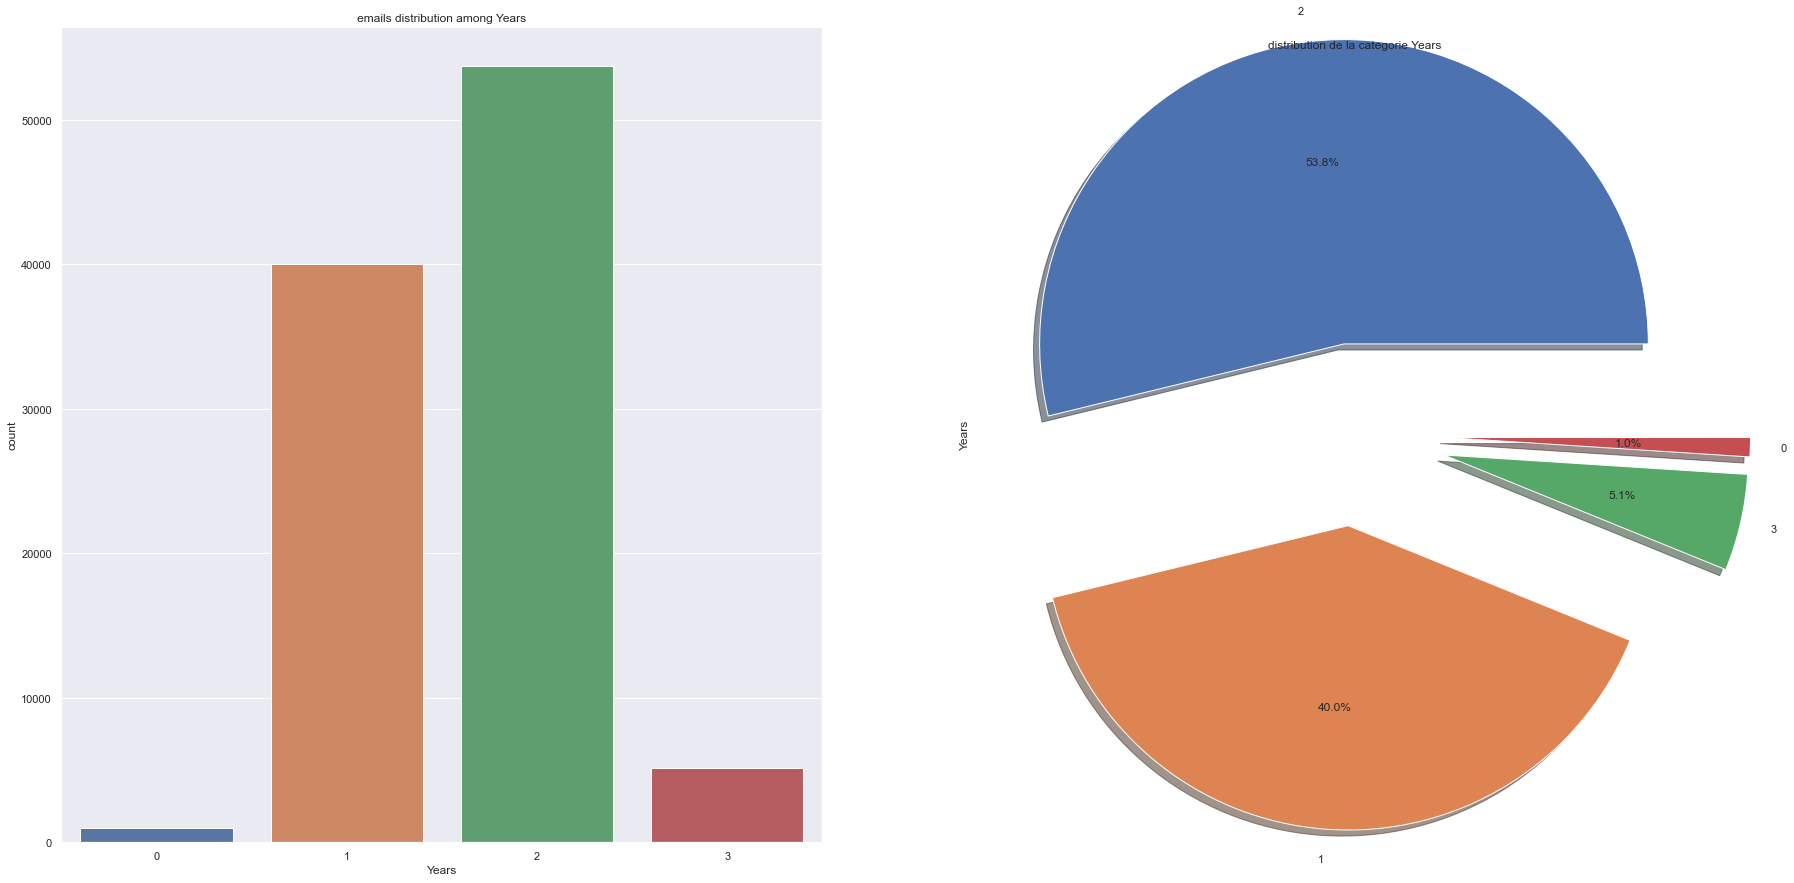

In [6]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(30,15))
print(df['Years'].value_counts())
sns.countplot(x='Years', data=df, ax=ax1)
ax1.set_title('emails distribution among Years')

df['Years'].value_counts().plot.pie(explode=[0.3,0.3,0.3,0.3],autopct='%1.1f%%',ax=ax2,shadow=True)
ax2.set_title('distribution de la categorie Years')
plt.show()

La <b>distribution des classes</b> est tès importante lorsqu'on fait une classification.

- L'année <b>1999</b> représente <b>1%</b> des mails.
- L'année <b>2000</b> représente <b>40%</b> des mails.
- L'année <b>2001</b> représente <b>53,8%</b> des mails.
- L'année <b>2002</b> représente <b>5,1%</b> des mails.

Les années <b>1999 et 2002</b> sont sous représentées par rapport aux années <b>2000 et 2001</b>, nous sommes en présence de ce que l'on appelle un <b>Imbalanced dataset</b>. Si nous ne prenons pas en compte ce cas particulier, nos modèles risque d'<b>ignorer les classes minoritaires</b>. On pourrait alors avoir une <b>bonne précision générale</b>, mais une <b>mauvaise précision de classification au sein des classes</b>.


<h1> EXPLIQUER pourquoi on resample avec pipeline durant cross val et pas avant</h1>

In [114]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter


In [112]:
y_train.value_counts()

2    38654
1    28841
3     3700
0      742
Name: Years, dtype: int64

In [178]:
lg = DecisionTreeClassifier()

pipeline = imbalanced_make_pipeline(oversample_train, undersample_train, lg)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Logistic Regression training score: ', scores)


#balanced_score = balanced_accuracy_score(y_test, y_pred)
#print('LogisticRegression balanced accuracy validation score: ', balanced_score)

#matrix = confusion_matrix(y_test, y_pred)
#sns.heatmap(matrix, annot=True, fmt='2.0f')

Logistic Regression training score:  [0.94815853 0.94415532 0.94155324 0.94935442 0.9495546  0.93784406
 0.94775298 0.93754379 0.94294865 0.94715244 0.94505604 0.94305444
 0.94295436 0.94895406 0.94334901 0.94084676 0.93664298 0.94124712
 0.94314883 0.94505055 0.94705765 0.94575661 0.94825861 0.94334901
 0.94715244 0.93924532 0.94775298 0.94615154 0.94705235 0.94705235]


In [62]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score
models = []
acc_training = []
acc_test = []

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

<br>
<h3>I - splitting data.</h3>

Tout d'abord, nous devons séparer nos données en 2:

- le <b>train set</b>: le jeu de données qui servira d'<b>entraînement</b> à nos modèles.
- le <b>test set</b>: le jeu de données <b>final</b> (ou final test) qui devrait servir à faire notre choix final entre tous les modèles (ou aucun).

Ensuite nous allons séparer le <b> train set</b> en 2:

- Le <b>train set</b> (ou sub-train set): le jeu de données qui servira d'<b>exemple</b> à nos modèles.
- Le <b>validation set</b>: le jeu de données qui servira à <b>tester</b> (ou valider) les performances de nos modèles.


Avant de séparer nos données, nous allons standardiser les variables en soutrayant la moyenne et en mettant à l'échelle la variance unitaire. Standardiser les données peut permettre à certains modèles de converger beaucoup plus vite.

In [11]:
from sklearn.model_selection import train_test_split

In [91]:
X = df.drop(columns=['Years'])
y = df['Years']
print(X.columns)
scaler = StandardScaler()
X = scaler.fit_transform(X)

Index(['DayWeek', 'Cat_1_level_1', 'Cat_1_level_2', 'Cat_1_weight', 'Month',
       'Day', 'Hours', 'content_char_len', 'content_char_length_category',
       'To_count'],
      dtype='object')


In [179]:
X_train_origin, X_final_test, y_train_origin, y_final_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test =  train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [93]:
print('train set size: ' ,len(X_train))
print('validation set size: ', len(X_test))
print('final test set size: ', len(X_final_test))
      

train set size:  71937
validation set size:  7993
final test set size:  19983


In [203]:
def over_undersample(X, valid=False):
    if valid:
        len_1999 = round(len(X)/10)
        len_2000 = round((len(X)/10))*2
        len_2001 = round((len(X)/10))*2
        len_2002 = round(len(X)/10)
    else:
        len_1999 = round(len(X)/5)
        len_2000 = round((len(X)/5))*2
        len_2001 = round((len(X)/5))*2
        len_2002 = round(len(X)/5)
    return(len_1999, len_2000, len_2001, len_2002)

#Resample for training
len_1999, len_2000, len_2001, len_2002 = over_undersample(X_train)
oversample_train = SMOTE(sampling_strategy={0:len_1999,3:len_2002})
undersample_train = RandomUnderSampler(sampling_strategy={1:len_2000,2:len_2001})

#Resample for cross validation
len_1999, len_2000, len_2001, len_2002 = over_undersample(X_train_origin, True)
oversample_train_origin = SMOTE(sampling_strategy={0:len_1999,3:len_2002})
undersample_train_origin = RandomUnderSampler(sampling_strategy={1:len_2000,2:len_2001})



<br>
<h3> II - Model building</h3>

C'est le moment de pré-choisir nos modèles, il existe beaucoup de classifier:

- Decision Tree Classifier

- K nearest neighbors 

- Support Vector Machine --> L'entraînement SVM avec des noyaux non linéaires, qui est par défaut dans SVC de sklearn, est approximativement en termes de complexité: O<b>(n_samples ^ 2 * n_features)</b>. On s'en passera donc ici.

- Random Forest Classifier

- ... il en existe énormément.


Dans <b>notre cas</b>, nous allons utiliser les suivants:

- <b>Decision Tree Classifier</b>

- <b>Random Forest Classifier</b>

- <b>Logistic Regression</b>

- <b>Perceptron</b>

- <b>Ensemble Learning</b> (Boosting)

- <b>Xgboost</b>

- <b>MLP Sequential</b>



Nous essaieront de les expliquer pas à pas.

<br>
<h4> a - Decision Tree Classifier </h4>

L'objectif est de créer un modèle qui prédit la valeur d'une variable cible (y) en apprenant des <b>règles de décision simples</b> déduites des caractéristiques (X) des données.

Il y a plusieurs <b>avantages</b> à utiliser les arbres de décision sont les suivants:

- Simple à comprendre et à interpréter. Les arbres peuvent être visualisés.

- Le coût d'utilisation de l'arbre (c'est-à-dire la prédiction des données) est <b>logarithmique</b> dans le nombre de points de données utilisés pour entraîner l'arbre.

- Utilise un modèle de boîte blanche. Si une situation donnée est observable dans un modèle, l'explication de la condition est facilement expliquée par la logique booléenne. En revanche, dans un modèle de boîte noire (par exemple, dans un réseau de neurones artificiels), les résultats peuvent être plus difficiles à interpréter.

Cependant, il y a aussi des <b>désavantages</b>:

- Les <b>Decision Tree learners</b> peuvent créer des arbres trop complexes qui ne <b>généralisent</b> pas bien les données. C'est ce qu'on appelle l'<b>overfitting</b>. Des mécanismes tels que l'<b>élagage</b>, la définition du nombre <b>minimum d'échantillons</b> requis au niveau d'un nœud feuille ou la définition de la <b>profondeur maximale</b> de l'arbre sont nécessaires pour éviter ce problème.

- Les Decision Tree learners créent des arbres biaisés si certaines classes <b>prédominent</b>. Il est donc recommandé d'équilibrer l'ensemble de données avant de le fit à l'arbre de décision.

Decision Tree training score:  0.9900051433893545
Decision Tree accuracy validation score:  0.9444513949705993
Decision Tree balanced accuracy validation score:  0.9140656100586237


<AxesSubplot:>

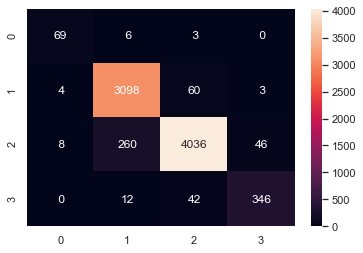

In [130]:
dtc = DecisionTreeClassifier()
pipeline_dtc = imbalanced_make_pipeline(oversample_train, undersample_train, dtc)

pipeline_dtc.fit(X_train, y_train)
y_pred = pipeline_dtc.predict(X_test)



training_score = pipeline_dtc.score(X_train,y_train)
test_score = accuracy_score(y_pred, y_test)
print('Decision Tree training score: ', training_score)
print('Decision Tree accuracy validation score: ', test_score)

balanced_score = balanced_accuracy_score(y_test, y_pred)
print('Decision Tree balanced accuracy validation score: ', balanced_score)
matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix, annot=True, fmt='2.0f')

 

In [131]:
models.append('DecisionTreeClassifier')
acc_training.append(training_score)
acc_test.append(test_score)

<br>
<h4>b - Random Forest Classifier</h4>

Une <b>Random Forest</b> est un ensemble de <b>Decision Tree</b> généralement via une méthode de <b>bagging</b>. A quelques exceptions près, une Random Forest Classifier possède les mêmes <b>hyperparamètres</b> qu'un Decision Tree Classifier (Pour controler comment les abres grandissent), plus tous les <b>hyperparamètres</b> d'un <b>Bagging Classifier</b>. (explications: *Bagging methods*: Annexe ML, *hyperparamètres*: Annexe ML)

l'algorithme de Random Forest introduit un <b>caractère aléatoire</b> supplémentaire lors de la croissance des arbres. Plus précisemment, il recherche la meilleure caractéristique parmi un <b>sous-ensemble aléatoire</b> de caractéristiques.

Cet algorithme résulte donc en une très <b>grande diversité</b> d'arbre, ce qui donne lieu à un <b>grand biais</b> pour une <b>faible variable</b>, ce la donne généralement un <b>meilleur modèle global<b>.
    
Une <b>grande qualité</b> des Random Forest est qu'elles rendent facile <b>la mesure de l'importance relative</b> de chaque variable. Sklearn mesure l'importance d'une variable en regardant comment les noeuds des arbres qui utilisent cette variable réduisent en moyenne l'impureté. 
Plus précisement, c'est une <b>moyenne pondérée</b>, où chaque <b>poids</b> d'un noeud est égale au nombre d'<b>échantillons</b> d'entraînement qui y est associé.

Random Forest training score:  0.989907836023187
Random Forest validation score:  0.9439509570874515
RandomForest balanced accuracy validation score:  0.8963638739780675


<AxesSubplot:>

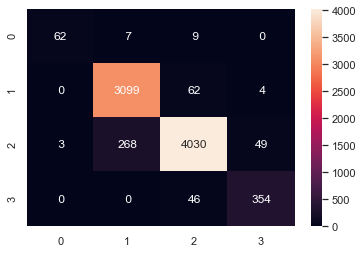

In [132]:
rfc = RandomForestClassifier()
pipeline_rfc = imbalanced_make_pipeline(oversample_train, undersample_train, rfc)

pipeline_rfc.fit(X_train, y_train)
y_pred = pipeline_rfc.predict(X_test)

training_score = pipeline_rfc.score(X_train,y_train)
test_score = accuracy_score(y_pred, y_test)
print('Random Forest training score: ', training_score)
print('Random Forest validation score: ', test_score)

balanced_score = balanced_accuracy_score(y_test, y_pred)
print('RandomForest balanced accuracy validation score: ', balanced_score)

matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix, annot=True, fmt='2.0f')

In [133]:
models.append('RandomForestClassifier')
acc_training.append(training_score)
acc_test.append(test_score)

<br>
<h4>c - Logistic Regression</h4>



<b>Logistic Regression</b> est souvent utilisé pour estimer la <b>probabilité</b> qu'une instance fasse partie d'une classe particulière. 
Si la <b>probabilité estimée</b> est plus grande que 50%, alors le modèle prédit que l'instance fait partie de cette classe (la classe <b>positive</b>) et sinon le modèle prédit que l'instance ne fait pas partie de cette classe (mais de la classe <b>négative</b>). Cela en fait donc un <b>classifier binaire</b>, ce qui n'est pas ce que l'on veut.



En fait, ce modèle peut aussi être appliqué à des problèmes <b>multiclasses</b>, le modèle s'appelle alors <b>Multinomial Logistic Regression</b>. Cependant, le modèle multinomial de la logistic regression est particulièrement important pour des modèles sophistiqués utilisés en <b>deep learning</b>.

La Logistic Regression est également intéressante car nous prenons nos variables d'entrées, les transformons via une <b>combinaison linéaire</b> des poids(weights) (à savoir A1 · X1 + A2 · X2 + A3 · X3 ...), puis les exécutons via une fonction <b>non linéaire</b>.

Soit <b>F</b> la fonction reprensentant l'<b>estimation</b> de probabilité la <b>probabilité totale</b> d'un jeu de données est:

$Probability = \prod_{n=1}^{n}(F(X_i))^{y_i}.(1-F(X_i))^{1-y_i} $

L'objectif sera alors de <b>maximiser</b> cette probabilité. On peut le faire en prenant la <b>dérivée</b> par rapport à nos poids (weights) en définissant la dérivée à 0. Nous pouvons ensuite exécuter une <b>descente de gradient</b> en utilisant notre gradient calculé pour obtenir nos poids optimaux.

le modèle de Logistic Regression a une description assez simple, peut être entraîné assez rapidement grâce à des techniques telles que la descente de gradient en raison de sa  dérivée, et fonctionne souvent bien dans la pratique.

Logistic Regression training score:  0.5763932329677357
Logistic Regression validation score:  0.5795070686850995
LogisticRegression balanced accuracy validation score:  0.5154953596615837


<AxesSubplot:>

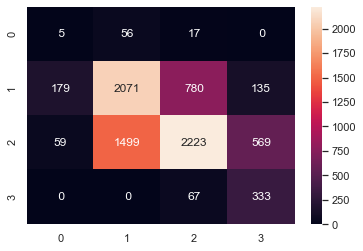

In [134]:
lg = LogisticRegression(max_iter=300)
pipeline_lg = imbalanced_make_pipeline(oversample_train, undersample_train, lg)

pipeline_lg.fit(X_train, y_train)
y_pred = pipeline_lg.predict(X_test)
training_score = pipeline_lg.score(X_train,y_train)
test_score = accuracy_score(y_pred, y_test)
print('Logistic Regression training score: ', training_score)
print('Logistic Regression validation score: ', test_score)


balanced_score = balanced_accuracy_score(y_test, y_pred)
print('LogisticRegression balanced accuracy validation score: ', balanced_score)

matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix, annot=True, fmt='2.0f')

In [135]:
models.append('Logistic Regression')
acc_training.append(training_score)
acc_test.append(test_score)


<h4>d - KNearestNeighbours</h4>

Logistic Regression training score:  0.933427860489039
Logistic Regression validation score:  0.855373451770299
LogisticRegression balanced accuracy validation score:  0.8548162983309657


<AxesSubplot:>

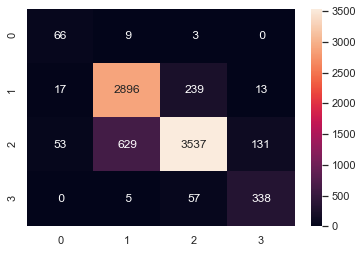

In [138]:
knn = KNeighborsClassifier(n_neighbors=3)
pipeline_knn = imbalanced_make_pipeline(oversample_train, undersample_train, knn)

pipeline_knn.fit(X_train, y_train)
y_pred = pipeline_knn.predict(X_test)
training_score = pipeline_knn.score(X_train,y_train)
test_score = accuracy_score(y_pred, y_test)
print('KNearestNeighbours training score: ', training_score)
print('KNearestNeighbours validation score: ', test_score)


balanced_score = balanced_accuracy_score(y_test, y_pred)
print('KNearestNeighbours balanced accuracy validation score: ', balanced_score)

matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix, annot=True, fmt='2.0f')

In [ ]:
models.append('KNearestNeighbours')
acc_training.append(training_score)
acc_test.append(test_score)



<br>
<h4> d - Perceptron </h4>

Le <b>Perceptron</b> est un autre algorithme de classification simple adapté à l'apprentissage à <b>grande échelle</b>. Il est sûrement l'un des plus simple <b>ANN</b> (Articial neural network).

Le pereceptron est basé sur un neurone artificiel appelé <b>threshold logic unit</b> (TLU). Les entrées et sorties sont des nombres. 

Chaque connection d'entrée est associé avec un <b>poids</b>. Le <b>TLU</b> une <b>somme</b> de poids des entrées. Puis applique une <b> step function </b> à cette somme et donne en sorties le résultat.

Un seul TLU peut être utilisé pour une <b>simple classification linéaire binaire</b>. Il calcule une <b> combinaison linéaire</b> des entrées et si le résultat dépasse le <b>seuil</b> (threshold de la step function) la sortie (prédiction) sera la <b>classe positive</b> sinon la sortie est la <b>classe négative</b> (comme la Logistic Regression).

Un perceptron est simplement composé de plus d'un <b>seule couche de plusieurs</b> TLU avec chaque TLU connecté à toutes les entrées.

Lorsque tous les neurones dans une couche sont connecté à tout neurone de la couche précédent (neurons d'entrée), la couche est appelé <b>fully connected layer</b>. les entrées du perceptron sont acheminées vers des neurones transitoires spéciaux appelés <b>neurones d'entrée</b>: ils sortent les entrées auxquelles ils sont alimentés.

Si perceptron a 2 entrées et 3 sorties, il peut classifier les instances simultanéments en 3 différentes classes binaire, cela fait du pereceptron un <b>classifier multioutput</b>.

Ce modèle se met à jour <b>uniquement sur les erreurs</b>.

In [20]:
from sklearn.linear_model import Perceptron

Perceptron training score:  0.5553887429278397
Perceptron validation score:  0.5692480920805705
LinearRegression balanced accuracy validation score:  0.45621856942017514


<AxesSubplot:>

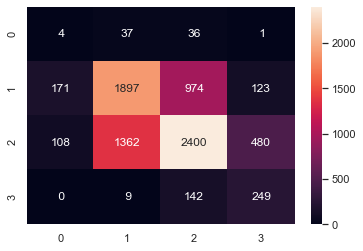

In [140]:
perceptron = Perceptron(tol = 1e-3, random_state = 0)
pipeline_neur = imbalanced_make_pipeline(oversample_train, undersample_train, perceptron)

pipeline_neur.fit(X_train, y_train)
y_pred = pipeline_neur.predict(X_test)
training_score = pipeline_neur.score(X_train,y_train)
test_score = accuracy_score(y_pred, y_test)
print('Perceptron training score: ', training_score)
print('Perceptron validation score: ', test_score)

balanced_score = balanced_accuracy_score(y_test, y_pred)
print('LinearRegression balanced accuracy validation score: ', balanced_score)

matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix, annot=True, fmt='2.0f')

In [141]:
models.append('Perceptron')
acc_training.append(training_score)
acc_test.append(test_score)


<br>
<h4> e - Boosting</h4>

Le <b>boosting</b> réfère à tout <b> Ensemble method</b> qui peut <b>transformer</b> plusieurs <b>learners faible</b> en un <b>learner fort</b>. L'idée générale des <b>Boosting methods</b> est d'entrainer des prédicteurs par <b>séquence</b>. Plus précisement, chaque prédicteur essaie de <b>corriger</b> son prédecesseur. (*Ensemble method*: voir annexe ML)

Ici, nous allons utiliser <b>AdaBoost</b> (Adaptive Boosting).

Un moyen pour un nouveau prédicteur de corrier son prédécesseur est d'accorder plus d'attention aux instances d'entraînements que son predecesseur a <b>underfit</b> (sous ajustés). Cela résulte en un nouveau prédicteur concentré de plus en plus sur les <b>cas difficiles</b>. C'est la technique utilisée par <b>Adaboost</b>

In [143]:
from sklearn.ensemble import AdaBoostClassifier

AdaBoost with DecisionTree training score:  0.9895047055062068
AdaBoost with DecisionTree validation score:  0.9465782559739773
Adaboost balanced accuracy validation score:  0.9123771192921585


<AxesSubplot:>

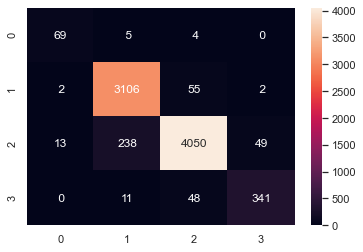

In [144]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(), n_estimators=200, algorithm="SAMME.R", learning_rate=0.5)

pipeline_ada = imbalanced_make_pipeline(oversample_train, undersample_train, ada_clf)
pipeline_ada.fit(X_train, y_train)
y_pred = pipeline_ada.predict(X_test)
training_score = pipeline_ada.score(X_train, y_train)
test_score = accuracy_score(y_pred, y_test)
print('AdaBoost with DecisionTree training score: ', training_score)
print('AdaBoost with DecisionTree validation score: ', test_score)


balanced_score = balanced_accuracy_score(y_test, y_pred)
print('Adaboost balanced accuracy validation score: ', balanced_score)

matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix, annot=True, fmt='2.0f')

In [145]:
models.append('Adaboost with DecisionTree')
acc_training.append(training_score)
acc_test.append(test_score)


<br>
<h4> f - Xgboost</h4>

<b>XGBoost</b> (Extreme Gradient Boosting) est une implémentation de l'algorithme <b>Gradient Tree Boosting</b> qui est largement reconnu pour son efficacité et sa précision prédictive. <b>Gradient Tree Boosting</b> entraîne un <b>ensemble d'arbre de décision</b> en entraînant chaque arbre à <b>prédire l'erreur de prédiction</b> de tous les arbres précédents de l'ensemble.

XGBoost vise à être <b>très rapide</b>, <b>scalable</b> et <b>portable</b>.

In [147]:
from xgboost import XGBClassifier

xgboost training score:  0.7006269374591657
xgboost validation score:  0.6988615038158389
Xgboost balanced accuracy validation score:  0.6382358123708834


<AxesSubplot:>

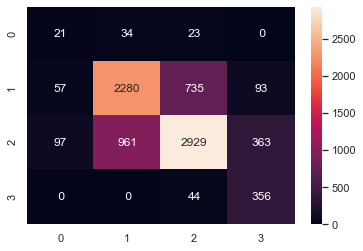

In [148]:
boost = XGBClassifier()
pipeline_xgb = imbalanced_make_pipeline(oversample_train, undersample_train, boost)

pipeline_xgb.fit(X_train, y_train)
y_pred = pipeline_xgb.predict(X_test)

training_score = pipeline_xgb.score(X_train, y_train)
test_score = accuracy_score(y_pred, y_test)
print('xgboost training score: ', training_score)
print('xgboost validation score: ', test_score)

balanced_score = balanced_accuracy_score(y_test, y_pred)
print('Xgboost balanced accuracy validation score: ', balanced_score)

matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix, annot=True, fmt='2.0f')

In [149]:
models.append('xgboost')
acc_training.append(training_score)
acc_test.append(test_score)

<br>
<h4>g - MLP Classification</h4>

Un <b>MLP</b> ou (Multi Layers Perceptron) est composé d'une <b>couche d'entrée</b> (input layer), d'<b>une ou plusieurs</b> couche de TLUs (hidden layers) et d'une <b>couche finale</b> de TLUs. Chaque couche (sauf la couche de sortie) comprend un <b>neurons biais</b> (fonction d'activation est en permanence égale à 1) et est **<b>fully connected</b>** à la couche suivante.

Lorsqu'un <b>ANN </b>contient une pile profonde de <b> hidden layers</b> (couche cachée), on appelle ce ANN un <b>DNN</b> (deep neural network). Le domaine du <b>Deep Learning</b> étudie ces DNNs.

In [154]:
from tensorflow import keras

In [155]:
X_train.shape

(71937, 10)

<h4>Création de notre modèle en utilisant l'API <b>Sequential</b> de Keras.</h4>

- La <b>première ligne</b> de code crée un modèle <b>Sequential</b>. C'est le genre de modèle le plus simple dans Keras pour les réseaux de neurones. Ce modèle est composé d'une <b>seule pile</b> de couche </b>connectée séquentiellement</b>.

In [152]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced',classes=np.unique(y_train.to_numpy()),y= y_train.to_numpy())

In [156]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[10]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(90, activation="relu"))
model.add(keras.layers.Dense(30, activation="relu"))
model.add(keras.layers.Dense(4, activation="softmax"))

- Ensuite dans la <b>seconde ligne</b>, nous construisons la première couche et l'ajoutons au modèle. C'est une couche <b>Flatten</b> dont le rôle est de convertir chaque entrée en un tableau d'une dimension. Cette est couche est seulement là pour faire du preprocessing.

- Nous ajoutons ensuite une couche <b> Dense</b> avec <b> 300 neurons</b>. Cette couche utilise la fonction d'activation <b>ReLU</b>.
    - Chaque couche <b>Dense</b> gère sa propre <b>matrice des poids</b>, contenant toutes les poids de connections entre les neurons et leurs entrées. elle gère aussi un vecteur de biais.
    
    
- Nous ajoutons ensuite deux autres Dense couche (toujours hidden layers).

- Finalement on ajoute  une couche de <b>sortie Dense</b> (output layer) avec 3 (le 4 est exclu) neurones (1 par classe), en utilisant la fonction d'activation <b> softmax</b> car nos classes sont exclusives.



In [157]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam",class_weight=class_weight, metrics=["accuracy"])

Avant de fit nos données, on doit compiler notre modèle.
Quelques explications sur le choix des paramètres:

- Nous utilisons <b>sparse_categorical_crossentropy</b> car nous avons des <b>sparse</b> labels (clairsemé) et que chaque classe est <b>exclusive</b>.

- Nous utilisons l'optimiseur <b> adam</b> c'une extension de la <b>descente de gradient stochastique</b>.
    

In [158]:
history = model.fit(X_train, y_train.to_numpy(), epochs=50, validation_data=(X_test, y_test.to_numpy()), verbose=0)

Train on 71937 samples, validate on 7993 samples
Epoch 1/30
71937/71937 [==============================] - 14s 193us/sample - loss: 0.6691 - accuracy: 0.6939 - val_loss: 0.6318 - val_accuracy: 0.7084
Epoch 2/30
71937/71937 [==============================] - 10s 137us/sample - loss: 0.6263 - accuracy: 0.7111 - val_loss: 0.6162 - val_accuracy: 0.7180
Epoch 3/30
71937/71937 [==============================] - 13s 180us/sample - loss: 0.6159 - accuracy: 0.7171 - val_loss: 0.6051 - val_accuracy: 0.7219
Epoch 4/30
71937/71937 [==============================] - 14s 190us/sample - loss: 0.6082 - accuracy: 0.7219 - val_loss: 0.6114 - val_accuracy: 0.7196
Epoch 5/30
71937/71937 [==============================] - 14s 198us/sample - loss: 0.6020 - accuracy: 0.7257 - val_loss: 0.5981 - val_accuracy: 0.7289
Epoch 6/30
71937/71937 [==============================] - 15s 207us/sample - loss: 0.5964 - accuracy: 0.7300 - val_loss: 0.5936 - val_accuracy: 0.7335
Epoch 7/30
71937/71937 [=====================

MLP training score:  0.7006269374591657
MLP validation score:  0.9813586888527461
MLP balanced accuracy validation score:  0.9511985314761503


<AxesSubplot:>

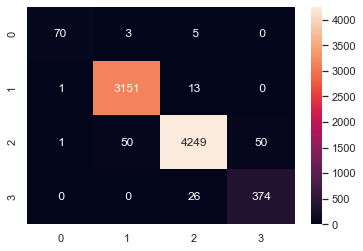

In [160]:
y_pred = model.predict_classes(X_test)

test_score = accuracy_score(y_pred, y_test)
print('MLP training score: ', training_score)
print('MLP validation score: ', test_score)

balanced_score = balanced_accuracy_score(y_test, y_pred)
print('MLP balanced accuracy validation score: ', balanced_score)

matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix, annot=True, fmt='2.0f')

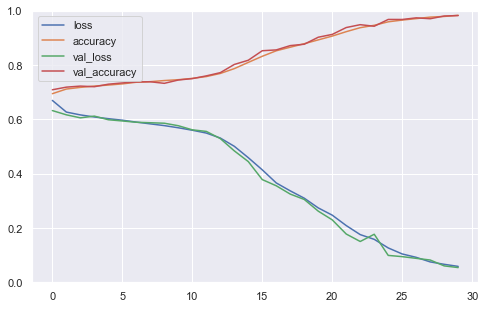

In [161]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

- <b>Train Learning Curve</b> (ici loss & accuracy): courbe d'apprentissage calculée à partir de l'ensemble de données d'entraînement qui donne une idée de la qualité d'apprentissage du modèle.

- <b>Validation Learning Curve</b> (ici val_loss & val_accuracy): courbe d'apprentissage calculée à partir d'un ensemble de données de validation d'attente qui donne une idée de la façon dont le modèle se généralise.

- learning curve montre un <b>sous-ajustement</b> (underfitting) si:

    - La courbe <b>loss training</b> reste stable quelle que soit le training.

    - La courbe <b>loss training</b> continue de diminuer jusqu'à la fin du training.

    - Dans <b>notre cas</b>, on peut voir que nous ne sommes pas dans un cas d'underfitting.
    
 - Les learning curves montre un <b>sur-ajustement</b> (overfitting) si:

    - La courbe <b>loss training</b> continue de diminuer avec l'expérience.
    
    - La courbe <b>loss validation</b>  diminue jusqu'à un certain point et recommence à augmenter.

- Mauvaise nouvelle, nous sommes en cas d'<b>overfitting</b>. Pour régler ce problème, on peut éventuellement modifier les paramètres de notre modèle.


<br>
<h4>j - Quels modèles choisir?</h4>

In [170]:
result = pd.DataFrame(data={'model': models, 'training score':acc_training, 'validation score':acc_test})
result

,model,training score,validation score
0,DecisionTreeClassifier,0.990005,0.944451
1,RandomForestClassifier,0.989908,0.943951
2,Logistic Regression,0.576393,0.579507
3,Perceptron,0.555389,0.569248
4,Adaboost with DecisionTree,0.989505,0.946578
5,xgboost,0.700627,0.698862


Le <b>DecisionTreeClassifier</b>, le <b>RandomForestClassifier</b> ainsi que <b> Adaboost</b> semble être les plus performants. Ils sont peut être même trop performant. Pour bien choisir notre modèle, nous devons verifier, qu'il ne tend pas à l'<b>over fitting</b> ou l'<b>under fitting</b>.

Rappel:

- <b>Overfitting</b>: notre modèle correspond trop précisément aux données d'entraînements. Cela peut ne pas correspondre de manière fiable à des données futures.
- <b>Underfitting</b>: notre modèle ne peut ni modéliser les données d'entraînements ni généraliser à de nouvelles données. Cela est facile à détecter, le modèle a de mauvaises performances sur les données d'entraînements. Ce qui n'est pas n'autre cas.

<br>
<h3>III - learning curves & cross-validation</h3>

Les courbes d'apprentissages peuvent nous aider à choisir notre modèle. Elles peut mettre en évidence si notre modèle overfit ou underfit.
- Notre modèle <b>overfit</b>, si il y a un écart entre le score d'entraînement et le score de la cross-validation. Il y a une <b>grande variance</b>.

- Notre modèle <b>underfit</b>, si le score d'entraînement et de cross validation sont bas. Il y a un <b>grand biais</b>.

In [205]:

classifiers = {
    "RandomForest": RandomForestClassifier(),
    "KnearestNeighbours": KNeighborsClassifier(),
     "Adaboost":AdaBoostClassifier(DecisionTreeClassifier(), n_estimators=200, algorithm="SAMME.R", learning_rate=0.5),
    "DecisionTreeClassifier": DecisionTreeClassifier()
   
}


model_name = []
acc_mean = []
acc_std = []

for key, classifier in classifiers.items():
    
    pipeline_clf = imbalanced_make_pipeline(oversample_train_origin, undersample_train_origin, classifier)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline_clf, X_train_origin, y_train_origin, scoring='accuracy', cv=cv, n_jobs=-1)
    
    model_name.append(key)
    acc_mean.append(np.mean(scores))
    acc_std.append(np.std(scores))


result = pd.DataFrame({'model': model_name, 'acc mean': acc_mean, 'acc std': acc_std})
  
result



Logistic Regression training score:  [0.89127987 0.9009133  0.89190542 0.89265607 0.90391593 0.89728512
 0.90917052 0.88527462 0.89640936 0.90166396 0.89841111 0.9049168
 0.9087952  0.8916552  0.90429125 0.88877768 0.88314775 0.89665958
 0.89928688 0.91667709 0.89603403 0.87126235 0.88414863 0.90291505
 0.89841111 0.90178907 0.89590892 0.88977856 0.89353184 0.89553359]
roc acc score:  0.9006755911422494
roc acc score:  0.004295872538333225
roc acc score:  0.7607906918553733
roc acc score:  0.004607245796659275
roc acc score:  0.8980024187831019
roc acc score:  0.00911663441439937
roc acc score:  0.895587805996914
roc acc score:  0.008171713115753385


,model,acc mean,acc std
0,RandomForest,0.900676,0.004296
1,KnearestNeighbours,0.760791,0.004607
2,Adaboost,0.898002,0.009117
3,DecisionTreeClassifier,0.895588,0.008172


Le <b>DecisionTreeClassifier</b>, le <b>RandomForest</b> et l'<b>Adaboost</b> (basé sur un decision tree) sont clairement en train d'<b>overfit</b>, l'écart entre la courbe d'entraînement et la courbe de cross-validation est grand. Cependant, plus le nombre d'exemple est grand, plus l'écart se réduit. Pour résoudre un problème d'overfitting on peut:

- Pour n'importe quel algorithme, <b>augmenter</b> la tailler des données peut aider à résoudre l'overfitting.

- Pour une <b>Random Forest</b> on peut:
    - <b>Augmenter le nombre d'estimateur</b>, plus il y a d'arbres, moins l'algorithme est susceptible d'overfit.
    - <b>Ajuster la profondeur maximale</b>, ce paramètre réduira la complexité des modèles appris, diminuant ainsi le risque d'overfitting.
    
    

- Pour un <b>Decision Tree</b> on peut:

    - <b>"Pré-tailler" l'arbre</b>, ce qui arrête la croissance de l'arbre plus tôt, avant de classer parfaitement l'ensemble d'entraînement.
    - <b>"Post-élagager" l'arbre</b>, ce qui permet à l'arbre de classer parfaitement l'ensemble d'entraînement, puis post-élaguer l'arbre.
    - Comme le précise la documentation de sklearn sur les arbres de décision:
    > The default values for the parameters controlling the size of the trees (e.g. max_depth, min_samples_leaf, etc.) lead to fully grown and <b>unpruned</b> trees which can potentially be very large on some data sets. To reduce memory consumption, the complexity and size of the trees should be controlled by setting those parameter values.
    
    
    
    
- Pour notre algorithme <b>Adaboost</b>, il est basé sur un arbre de décision, fixer un décision tree avec les <b>conditions précédentes</b> semble donc être une bonne idée.

- <b>Xgboost</b>, a un score d'entraînement très proche de celui de validation, on peut donc estimer qu'il n'y a pas d'overfitting dans son cas.


    

<br>
<h3> IV - Fine tuning models </h3>

Précédement, nous avons attribué des valeurs aux paramètres de nos modèles, bien que l'on a essayé de mettre des valeurs cohérentes, il se peut que ces valeurs ne soient pas les valeurs <b>optimales</b>.

Pour se rapprocher des valeurs optimales on va faire du <b>fine tuning</b> en utilisant <b>GridSearcgCV</b>. Il va s'occuper de tester une multitude de combinaisons de paramètres qu'on lui aura fourni. Il gardera ainsi la <b>meilleure combinaison</b>.

On va prendre maintenant seulement les modèles les plus performants selon nos critères (accuracy & generalization) car cela demande beaucoup de temps de calcul pour chercher la bonne combinaison pour chaque modèle.

In [18]:
from sklearn.model_selection import GridSearchCV
models_tune = []
best_scores = []

<br>

- <b>Random Forest</b>

In [19]:
grid_rf = GridSearchCV(estimator = RandomForestClassifier(), param_grid = {'bootstrap':[False,True],'n_estimators':[150],'max_depth':[17],
               'max_features':['auto','sqrt','log2']})
grid_rf.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [False, True], 'max_depth': [17],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [150]})

In [20]:
print(grid_rf.best_estimator_)
print(grid_rf.best_score_)

models_tune.append("Random Forest")
best_scores.append(grid_rf.best_score_)

RandomForestClassifier(bootstrap=False, max_depth=17, n_estimators=150)
0.8448472222222222


<br>

- <b>Decision Tree

In [178]:
grid_dc = GridSearchCV(DecisionTreeClassifier(), {'criterion':['gini','entropy'],'splitter':['best', 'random'],'max_depth':range(14,18),
               'max_features':['auto','sqrt','log2']} )
grid_dc.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(14, 18),
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'splitter': ['best', 'random']})

In [179]:
print(grid_dc.best_estimator_)
print(grid_dc.best_score_)

models_tune.append("Decision Tree")
best_scores.append(grid_dc.best_score_)

DecisionTreeClassifier(max_depth=17, max_features='auto')
0.7721944444444444


<br>

- <b>Adaboost</b>

In [167]:
dtc = DecisionTreeClassifier(max_depth = 14, max_features='sqrt')

abc = AdaBoostClassifier(dtc)

grid_abc = GridSearchCV(abc, param_grid={"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "n_estimators": range(20,200,30), "algorithm": ["SAMME.R"], "learning_rate":[0.5]
             })
grid_abc.fit(X_train, y_train)

GridSearchCV(estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=14,
                                                                                max_features='sqrt')),
             param_grid={'algorithm': ['SAMME.R'],
                         'base_estimator__criterion': ['gini', 'entropy'],
                         'base_estimator__splitter': ['best', 'random'],
                         'learning_rate': [0.5],
                         'n_estimators': range(20, 200, 30)})

In [168]:
print(grid_abc.best_estimator_)
print(grid_abc.best_score_)

models_tune.append("Adaboost")
best_scores.append(grid_abc.best_score_)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                         max_depth=14,
                                                         max_features='sqrt'),
                   learning_rate=0.5, n_estimators=170)
0.8924444444444444


<br>

- <b>Logistic Regression</b>

In [176]:
import warnings
warnings.filterwarnings("ignore")
lr = LogisticRegression()

grid_lr = GridSearchCV(lr, {"penalty":['l2',  'none'], "C":[0.001, 0.01, 0.1, 1, 10, 100, 1000], "max_iter":range(100, 500,100)})
grid_lr.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'max_iter': range(100, 500, 100),
                         'penalty': ['l2', 'none']})

In [177]:
print(grid_lr.best_estimator_)
print(grid_lr.best_score_)

models_tune.append("Logistic Regression")
best_scores.append(grid_lr.best_score_)

LogisticRegression(C=0.01)
0.708763888888889


- <b>Xgboost</b>

In [183]:
params = {'learning_rate': [0.05], 'max_depth': [6],'min_child_weight': [11],'silent': [1],'subsample': [0.8],'colsample_bytree': [0.7],'n_estimators': range(5,400,100),'seed': [1337]}
boost = XGBClassifier()

grid_bst = GridSearchCV(boost, params)
grid_bst.fit(X_train, y_train)


GridSearchCV(estimator=XGBClassifier(),
             param_grid={'colsample_bytree': [0.7], 'learning_rate': [0.05],
                         'max_depth': [6], 'min_child_weight': [11],
                         'n_estimators': range(5, 400, 100), 'seed': [1337],
                         'silent': [1], 'subsample': [0.8]})

In [184]:
print(grid_bst.best_estimator_)
print(grid_bst.best_score_)

models_tune.append("Xgboost")
best_scores.append(grid_bst.best_score_)

XGBClassifier(colsample_bytree=0.7, learning_rate=0.05, max_depth=6,
              min_child_weight=11, n_estimators=305, objective='multi:softprob',
              seed=1337, silent=1, subsample=0.8)
0.8157638888888888


<br>
Regardons les résultats après fine tuning.

In [22]:
result = pd.DataFrame(data={'model': ["Xgboost", "LogisticRegression", "Adaboost", "DecisionTree","RandomForest" ], 
                            "best_score":[0.8157638888888888, 0.708763888888889, 0.8924444444444444, 0.7721944444444444,
                                          0.8448472222222222
                                         ]})
result

,model,best_score
0,Xgboost,0.815764
1,LogisticRegression,0.708764
2,Adaboost,0.892444
3,DecisionTree,0.772194
4,RandomForest,0.844847


Après l'étape de <b>fine tuning</b>, il semblerait que les modèles <b>LogisticRegression</b> et <b>DecisionTreeClassifier</b> sont largement dépassé par les autres modèles. Cependant, ce n'est pas encore fini, s'il ne sont pas assez performant seul, peut être qu'<b>ensemble</b> ils peuvent rester dans la course.

C'est au tour du <b>VotingClassifier</b> de faire son apparition. Le VotingClassifier est une méthode de <b>Bagging</b>.
Ce Classifier permet d'utiliser plusieurs modèles à la fois.

In [19]:
from sklearn.ensemble import VotingClassifier

In [20]:
lg = LogisticRegression(C=0.01)
dtc = DecisionTreeClassifier(max_depth=17, max_features='auto')
voting_clf = VotingClassifier(estimators=[('lr', lg), ('dt', dtc)], voting='soft')
voting_clf.fit(X_train, y_train)
voting_clf.score(X_train, y_train)

0.823625

In [37]:
lg.fit(X_train, y_train)
dtc.fit(X_train, y_train)

#validation
y_lg = lg.predict(X_test)
y_dtc = dtc.predict(X_test)
y_vot = voting_clf.predict(X_test)

print("LogisticRegression score on test set: ", accuracy_score(y_lg, y_test))
print("DecisionTree score on test set: ", accuracy_score(y_dtc, y_test))
print("VotingClassifier score on test set: ", accuracy_score(y_vot, y_test))

LogisticRegression score on test set:  0.70575
DecisionTree score on test set:  0.77425
VotingClassifier score on test set:  0.787125


Super le <b>VotingClassifier</b> surpasse le LogisticRegression et DecisionTree.

<br>
<h4> Toujours over-fitting?</h4>
Certains de nos modèles avaient des problèmes d'<b>overfitting</b>. Est ce qu'après le <b>fine tuning</b> le problème est-il reglé?

In [25]:
models_tunes = {"Adaboost": AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=14, max_features='sqrt'),
                   learning_rate=0.5, n_estimators=170),
 "RandomForest": RandomForestClassifier(bootstrap=False, max_depth=17, n_estimators=150),
 "Xgboost": XGBClassifier(colsample_bytree=0.7, learning_rate=0.05, max_depth=6,
              min_child_weight=11, n_estimators=305, objective='multi:softprob',
              seed=1337, silent=1, subsample=0.8),
 "VotingClassifier":voting_clf
}
name_model = []
acc_train = []
acc_valid = []

for key, value in models_tunes.items():
    name_model.append(key)
    
    value.fit(X_train, y_train)
    acc_train.append(value.score(X_train, y_train))
    
    y_pred = value.predict(X_test)
    acc_valid.append(accuracy_score(y_pred, y_test))
    
    

In [27]:
models_tunes["MLP"] = model
name_model.append("Sequential MLP")
acc_train.append(np.mean(model.history.history['accuracy']))
y_pred = model.predict_classes(X_test)
acc_valid.append(accuracy_score(y_pred, y_test))



result_validation = pd.DataFrame(data={'model': name_model, 'training score': acc_train,  'validation score': acc_valid
                                         })
result_validation

,model,training score,validation score
0,Adaboost,0.992153,0.903875
1,RandomForest,0.884736,0.843625
2,Xgboost,0.836375,0.820625
3,VotingClassifier,0.821000,0.793750
4,Sequential MLP,0.894680,0.872625


- Le modèle <b>Adaboost</b> <b>sur-ajuste</b> (overfit) grandement les données. On va donc s'en passé, il ne <b>généralise</b> pas assez bien les données.

- Les modèles <b> Random Forest </b>, <b>Voting Classifier</b> et <b> Sequential MLP</b> overfit toujours un petit peu.

- Le <b>Xgboost Classifier</b> n'est pas le plus performant en précision, mais il semple être le plus fiable.

<h3>V - Classification metrics</h3>

Pour nous aidez à faire nos choix de modèle, il existe différentes manières de mesurer la précision des classifiers. Jusqu'à présent, nous avons étudié l'accuracy <b>pure</b>, c'est à dire, le pourcentage des mails qui étaient bien classifiés.

Cependant, il se peut que nos modèles classifient très bien les mails de <b>certaines</b> classes et très mal ceux d'<b>autres</b> classes. Pour éviter d'éventuel surprise, c'est un bon réflexe d'utiliser une <b>matrice de confusion</b>. Nous aurions pu l'utiliser plus tôt pour éliminer certains classifieurs, mais presque tout nos modèles séléctionnés avaient une <b>accuracy</b> supérieur à <b>80%</b> et les classes minoritaires au moins représentent <b>25%</b> des données.

In [43]:
matrices = []
for key, model in models_tunes.items():
    if(key == "MLP"):
        y_pred = model.predict_classes(X_test)
        matrices.append((key,confusion_matrix(y_test, y_pred)))
    
    elif(key == "Adaboost"):
        None
    else:
        y_pred = model.predict(X_test)
        
        matrices.append((key,confusion_matrix(y_test, y_pred)))

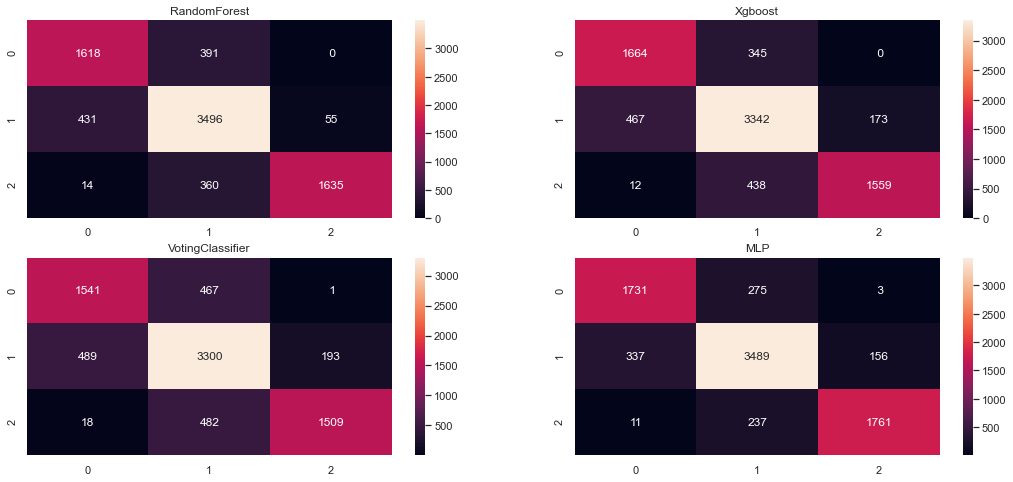

In [46]:
f,ax=plt.subplots(2,2,figsize=(18,8))
      
sns.heatmap(matrices[0][1], annot=True, fmt='2.0f', ax=ax[0][0])
ax[0][0].set_title(matrices[0][0])

sns.heatmap(matrices[1][1], annot=True, fmt='2.0f', ax=ax[0][1])
ax[0][1].set_title(matrices[1][0])

sns.heatmap(matrices[2][1], annot=True, fmt='2.0f', ax=ax[1][0])
ax[1][0].set_title(matrices[2][0])

sns.heatmap(matrices[3][1], annot=True, fmt='2.0f', ax=ax[1][1])
ax[1][1].set_title(matrices[3][0])
plt.show()

<br>
C'est une bonne nouvelle, nos quatres derniers classifiers performent aussi bien sur chaque classe. La classe 1 représente environ 25% de la diagonale, la classe 2 environ 50% et la classe 3 environ 25%, c'est la <b>même</b> distribution que la distribution réelle des classes.

<br>

Comment choisir notre classifieur final? Cela dépend on peut ici avoir <b>deux cas</b>:

- si on veut une <b>fiabilité forte</b> en notre classifieur, il faut choisir le <b>Xgboost Classifier</b>. C'est le classifieur qui semble être le moins dans le cas d'un overfitting.

- Si on n'attend pas forcément une bonne fiabilité, on peut choisir un modèle qui <b>performe plus</b> sur la précision, même si il <b>généralise moins</b> bien les données. Il faudra s'attendre à parfois être <b>beaucoup</b> moins performant si les nouvelles données que l'on veut predire s'éloignent de celle que le modèle connaît. Dans ce cas là on a le choix entre:

    - Le modèle <b>RandomForest</b>
    - Le modèle <b>VotingClassifier</b>
    - Le modèle <b>Sequential MLP</b>
    
    - Le modèle qui semble le plus performer des trois semble être le <b>Sequential MLP</b>, on va donc sélectionner ce modèle.

<h3>VI - Final test</h3>

Lorsque nous avons séparer nos données, nous avons laissé de côté un petit data set: le <b>final test set</b>. Il nous servira donc à tester nos deux modèles une dernière fois.

- <b>XGBoost</b>

accuracy score of XGBoost classifier:  0.81555


<AxesSubplot:>

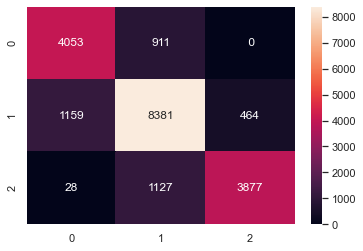

In [49]:
xgb = XGBClassifier(colsample_bytree=0.7, learning_rate=0.05, max_depth=6,
              min_child_weight=11, n_estimators=305, objective='multi:softprob',
              seed=1337, silent=1, subsample=0.8)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_final_test)

matrix_xgb = confusion_matrix(y_final_test, y_pred)
acc_xgb = accuracy_score(y_final_test,y_pred)
print("accuracy score of XGBoost classifier: ", acc_xgb)
sns.heatmap(matrix_xgb, annot=True, fmt='2.0f')


<br>

- <b>Sequential MLP</b>

accuracy score of XGBoost classifier:  0.86985


<AxesSubplot:>

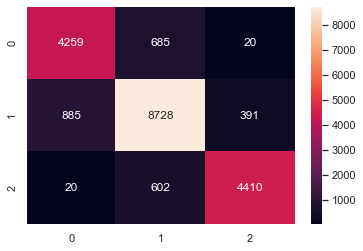

In [50]:
y_pred = model.predict_classes(X_final_test)


matrix_mlp = confusion_matrix(y_final_test, y_pred)
acc_mlp = accuracy_score(y_final_test,y_pred)
print("accuracy score of XGBoost classifier: ", acc_mlp)
sns.heatmap(matrix_mlp, annot=True, fmt='2.0f')

 


<br> 

<b>Finalement</b>:

Nos deux modèles semblent respecter leurs engagements, nous pouvons donc affirmer que ce sont nos deux meilleurs modèles pour ces données et ce cas d'utilisation (classification des mails en fonction de la catégorie de longueur du contenu). 

<br>
sources:

- sklearn <b>SVM complexity</b>: https://scikit-learn.org/stable/modules/svm.html#complexity


- sklearn <b>DecisionTree</b>:
    - https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
    - https://scikit-learn.org/stable/modules/tree.html#tree
    
    
- <b> Learning curves</b>:
    - https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/
    - https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py
    
    
- <b>Ensemble</b> methods :
    - Machine Learning with scikit-learn, Keras & TensorFlow de Aurélien Géron.
            
            
- <b>Bagging</b> methods:
    - https://scikit-learn.org/stable/modules/ensemble.html#forest
    - Hands on Machine Learning with scikit-learn, Keras & TensorFlow p 189 de Aurélien Géron.
    
    
- <b>Hyperparamètres</b>:
    - https://scikit-learn.org/stable/modules/grid_search.html
    - Hands on Machine Learning with scikit-learn, Keras & TensorFlow p 31 de Aurélien Géron.

